In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read data
data = pd.read_csv('data/HCV-Egy-Data.csv')

In [3]:
# Number of numerical and categorical features
print("Number of numerical features", len(data.select_dtypes(exclude='object').columns))
cat_features = data.select_dtypes(include='object').columns
print("Number of categorical features", len(cat_features))
print(cat_features)

Number of numerical features 29
Number of categorical features 0
Index([], dtype='object')


In [4]:
data.columns

Index(['Age ', 'Gender', 'BMI', 'Fever', 'Nausea/Vomting', 'Headache ',
       'Diarrhea ', 'Fatigue & generalized bone ache ', 'Jaundice ',
       'Epigastric pain ', 'WBC', 'RBC', 'HGB', 'Plat', 'AST 1', 'ALT 1',
       'ALT4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24 w',
       'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF',
       'Baseline histological Grading', 'Baselinehistological staging'],
      dtype='object')

In [5]:
X = data.drop(['Baselinehistological staging'], axis=1)
y = data['Baselinehistological staging']
# Check distribution of target classes
y.value_counts()

Baselinehistological staging
4    362
3    355
1    336
2    332
Name: count, dtype: int64

In [6]:
# Split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train

array([0, 0, 0, ..., 3, 0, 3])

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Create a Random Forest Classifier for the feature selection
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the model to your training data
rf.fit(X_train, y_train)
# Get feature importances
feature_importances = rf.feature_importances_

In [10]:
# Determine the number of top features to select
n_top_features = 20
top_feature_indices = np.argsort(feature_importances)[::-1][:n_top_features]
X_train_selected = X_train[:, top_feature_indices]
X_test_selected = X_test[:, top_feature_indices]

In [11]:
# Create a Random Forest Classifier for classification
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) #class_weight='balanced'

# Fit the model to your training data with selected features
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Predict on the test data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
y_pred = rf_classifier.predict(X_test)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

In [13]:
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Confusion Matrix:')
print(confusion)

Accuracy: 0.3176895306859206
F1 Score: 0.3126301193002816
Precision: 0.3197198825015921
Recall: 0.3176895306859206
Confusion Matrix:
[[15 15 13 23]
 [21 17 23 12]
 [13  7 26 18]
 [ 6 10 28 30]]


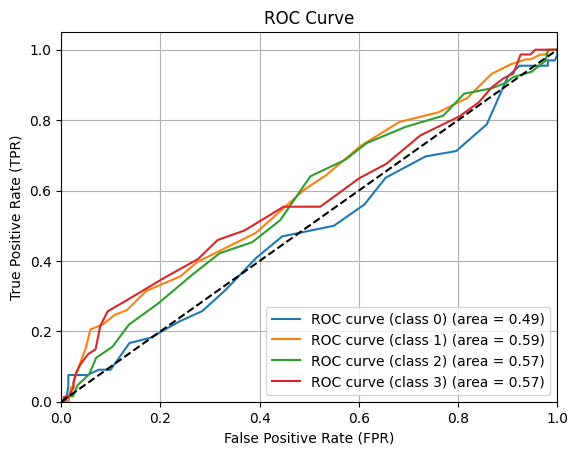

In [14]:
# Get class probabilities for the ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_probas = rf_classifier.predict_proba(X_test)

# Plot the ROC curve for each class
n_classes = len(label_encoder.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], label = roc_curve(y_test == i, y_probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.grid()
plt.legend(loc='lower right')
plt.show()